In [4]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [ ]:
genomic_dataset = pd.read_csv("../data/processed/genomic/dataset.csv.gz", index_col="MUTANT")
structural_dataset = pd.read_csv("../data/processed/structural/dataset.csv.gz", index_col="MUTANT")

integral_dataset = genomic_dataset.merge(structural_dataset, right_index=True, left_index=True, how="right", suffixes=("_genomic", "_structural"))
integral_dataset["TYPE"] = integral_dataset["TYPE_structural"]
integral_dataset.drop(["TYPE_genomic", "TYPE_structural"], 1, inplace=True)
# integral_dataset['random'] = np.random.random(size=len(integral_dataset))

In [ ]:
integral_dataset.to_csv("../data/processed/integral/dataset.csv.gz", index=True, index_label="MUTANT", compression="gzip")

In [5]:
integral_dataset = pd.read_csv("../data/processed/integral/dataset.csv.gz", index_col="MUTANT")

In [17]:
integral_dataset.shape

(68508, 64)

In [16]:
integral_dataset.PHYLOP46WAY.isnull().sum()

14119

In [6]:
cat_vars_genomic = ['INTRON','MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
       'NONSENSE', 'SPLICE', 'STOP-LOSS']

cat_vars_structural = ['BINDING','ACT_SITE','SITE','LIPID','METAL','CARBOHYD',
                       'DNA_BIND','NP_BIND','CA_BIND','DISULFID','SE_CYS','MOD_RES','PROPEP','SIGNALP',
                       'TRANSMEM','COMPBIAS','REP','MOTIF','ZN_FING','REGIONS','PPI','RNABD','TF','LOC',
                       'MMBRBD','CHROM','POSTMODREC','POSTMODENZ']

cat_vars  = cat_vars_genomic + cat_vars_structural

cont_vars = integral_dataset.columns.drop(cat_vars + ["TYPE"], 1).tolist()

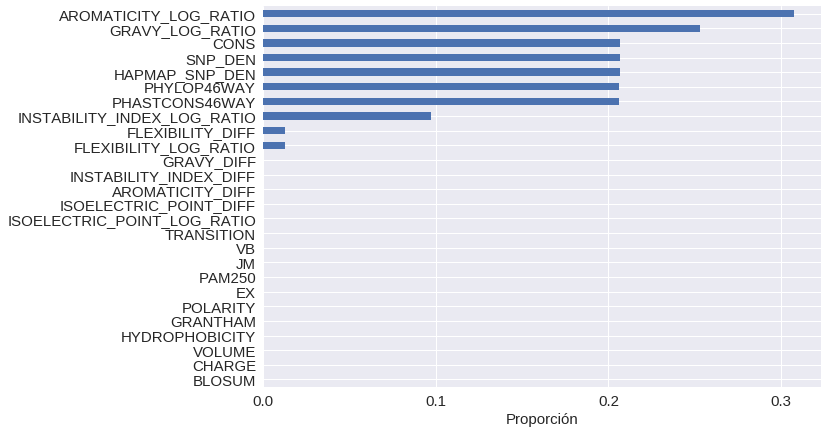

In [21]:
with_type = integral_dataset[cont_vars]
nulcount = (with_type.isnull().sum(axis=0) / with_type.shape[0]).sort_values(ascending=True)
plt.figure(figsize=(10,7))
# plt.title("Cantidad de variantes con valor nulo")
plt.yticks(size=15)
plt.xticks(np.arange(0, 2, 0.1), size=15)

plt.xlabel("Proporción", size=15)
ax = nulcount.plot(kind="barh")

# plt.savefig("proporcion_nulos.pdf", bbox_inches='tight')
